In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import pandas as pd

EOSINOPHIL_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL'
]

LYMPHOCYTE_dir = [ r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE']

MONOCYTE_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE'
]

NEUTROPHIL_dirs = [
    r'/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL'
]

filepaths = []
labels = []
dict_lists = [EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths      labels
0  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
1  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
2  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
3  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
4  /kaggle/input/blood-cells/dataset2-master/data...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


In [4]:
bloodCell_df.shape

(9957, 2)

In [5]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


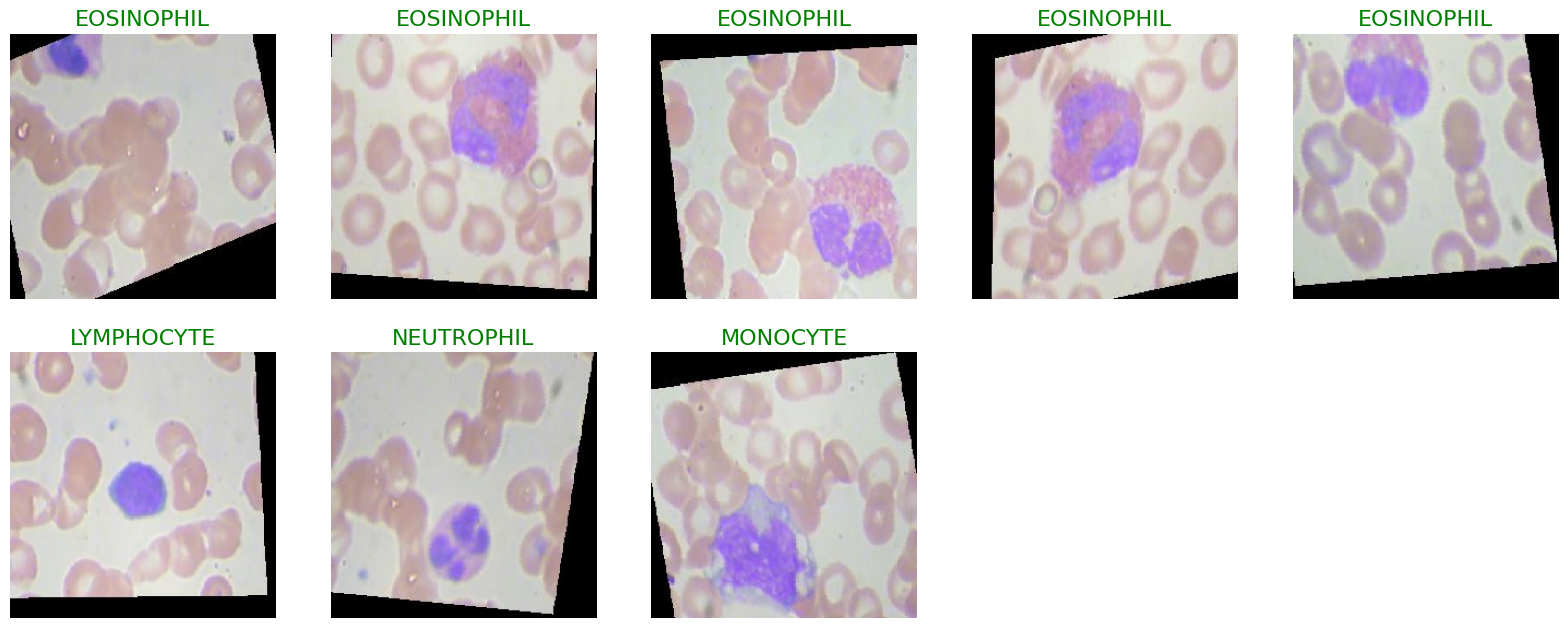

In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [10]:
tf.__version__

'2.16.1'

In [11]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
model = models.Sequential([
    layers.SeparableConv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.SeparableConv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.SeparableConv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=[Precision(), Recall(), 'accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 73, 73, 128)    │           704 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 73, 73, 128)    │        19,712 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 73, 73, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 73, 73, 256)    │        66,048 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 73, 73, 256)    │        66,048 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 36, 36, 512)    │       133,888 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 36, 36, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 18, 18, 512)    │       267,264 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 9, 9, 512)      │       267,26

 Total params: 2,713,668 (10.35 MB)

 Trainable params: 2,707,524 (10.33 MB)

 Non-trainable params: 6,144 (24.00 KB)

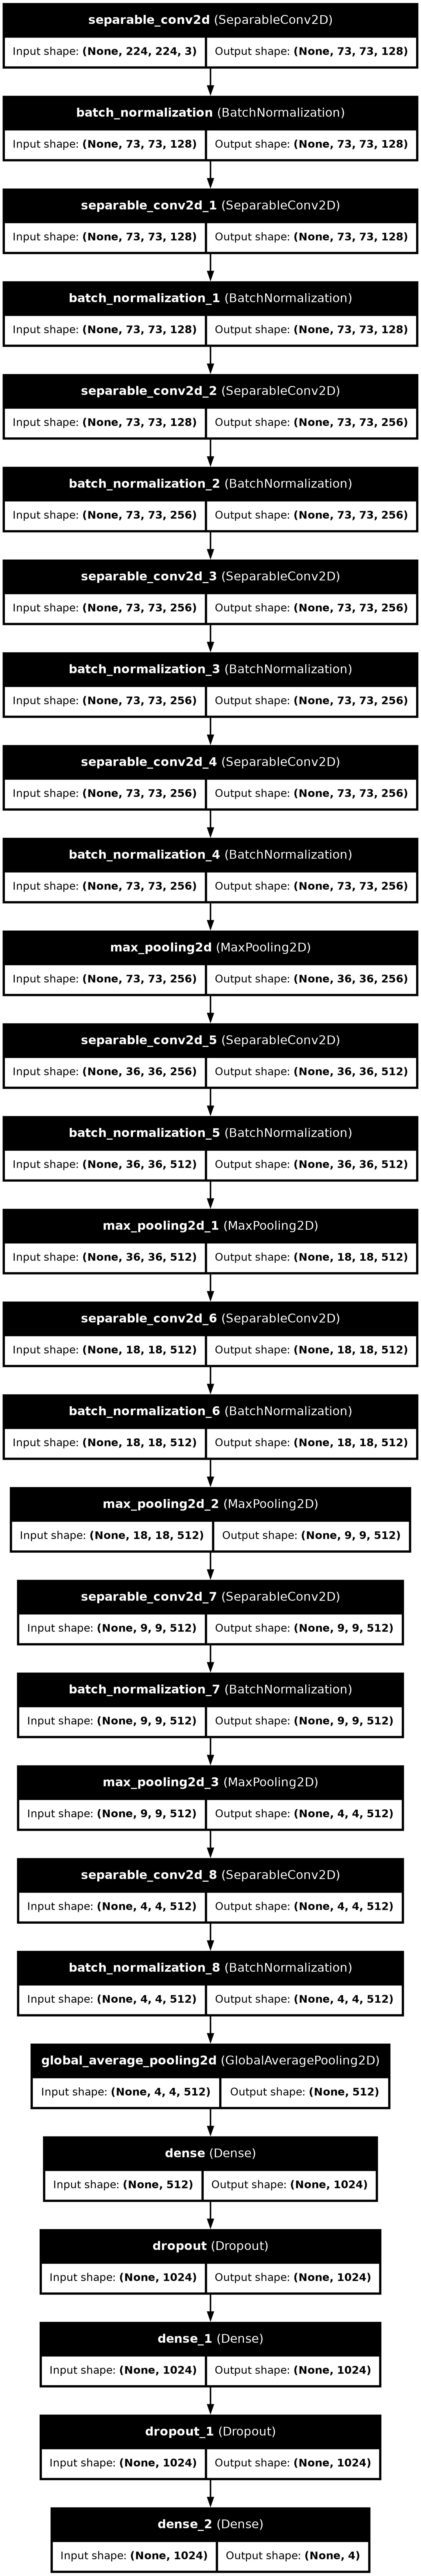

In [12]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Define callbacks including EarlyStopping
callbacks = [
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Added EarlyStopping
]

history = model.fit(train, epochs=50, validation_data=val, verbose=1,callbacks=callbacks)

Epoch 1/50


I0000 00:00:1725218003.464013      67 service.cc:145] XLA service 0x7e7930007c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725218003.464074      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/996 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.2917 - loss: 3.0532 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1725218011.987488      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


996/996 ━━━━━━━━━━━━━━━━━━━━ 87s 75ms/step - accuracy: 0.3165 - loss: 3.0634 - precision: 0.4643 - recall: 0.0069 - val_accuracy: 0.4478 - val_loss: 2.9374 - val_precision: 0.6499 - val_recall: 0.1556
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.5619 - loss: 2.7591 - precision: 0.7628 - recall: 0.2493 - val_accuracy: 0.6717 - val_loss: 2.5002 - val_precision: 0.7623 - val_recall: 0.5733
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.7664 - loss: 2.3045 - precision: 0.8434 - recall: 0.6631 - val_accuracy: 0.8770 - val_loss: 2.0005 - val_precision: 0.9185 - val_recall: 0.8368
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.8373 - loss: 2.1201 - precision: 0.8785 - recall: 0.7906 - val_accuracy: 0.7861 - val_loss: 2.1706 - val_precision: 0.8334 - val_recall: 0.7585
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.8823 - loss: 1.9990 - precision: 0.9070 - recall: 0.8534 - val_accuracy: 0.9488 - val_loss: 1.8

In [14]:
model.evaluate(test, verbose=1)

374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9952 - loss: 1.4224 - precision: 0.9952 - recall: 0.9952


[1.4166102409362793,
 0.9969879388809204,
 0.9969879388809204,
 0.9969879388809204]

In [15]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.99      1.00      0.99       781
  LYMPHOCYTE       1.00      1.00      1.00       764
    MONOCYTE       1.00      1.00      1.00       729
  NEUTROPHIL       1.00      0.99      0.99       714

    accuracy                           1.00      2988
   macro avg       1.00      1.00      1.00      2988
weighted avg       1.00      1.00      1.00      2988

Accuracy of the Model: 99.7%


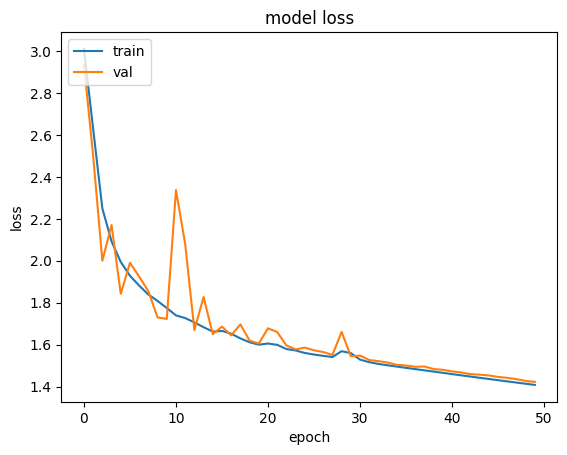

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

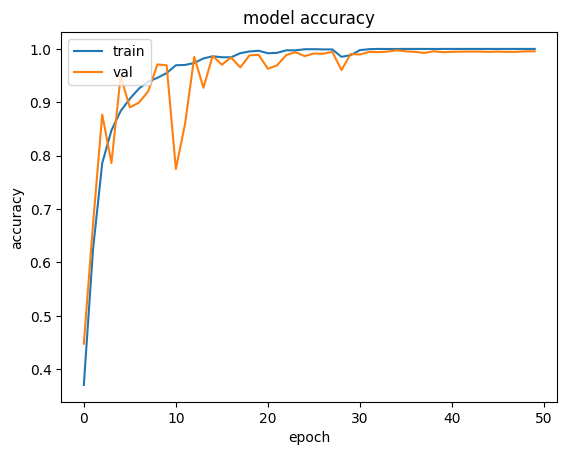

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

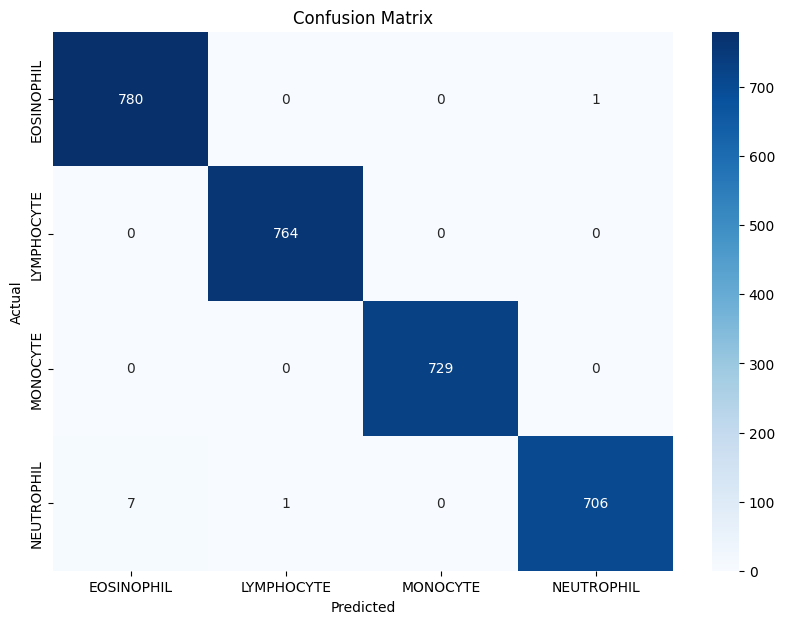

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()